# Imports

In [1]:
import numpy as np
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal
from torch.distributions import Categorical
from torch.utils.data import Dataset, Sampler, DataLoader
import multiprocessing as mp

import gym
import gym.spaces

import copy

from src.rl_environment import Environment, degree_cost
from src.graph_model import get_peo

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print (use_cuda)

def to_tensor(*args, **kwargs):
    return torch.Tensor(*args, **kwargs).to(device)

True


### PPO algorithm

In [3]:
env = Environment(
    'inst_2x2_7_0.txt',
    square_index=True,
    cost_function=degree_cost,
    simple_graph=True)
state_shape = (15, 15)

2018-11-23 18:05:23,181- INFO•	reading file inst_2x2_7_0.txt
2018-11-23 18:05:23,183- INFO•	There are 4 qubits in circuit
2018-11-23 18:05:23,185- INFO•	Generated graph with 10 nodes and 22 edges
2018-11-23 18:05:23,186- INFO•	last index contains from [9, 2, 5, 10]


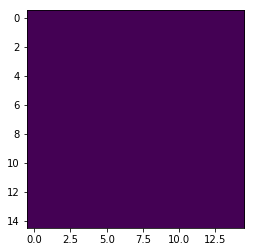

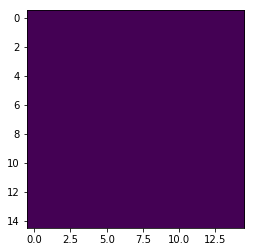

In [4]:
s = env.reset()
done = False
while not done:
    probs = np.ones(15) / 15
    mask = env.available_actions
    probs = probs * mask
    probs = probs / probs.sum()
    
    action = np.random.choice(15, p=probs)
    s, cost, done = env.step(action)
    plt.imshow(s)
    display.clear_output(wait=True)
    display.display(plt.gcf())

In [5]:
from models.sequential import SequentialNet, name2nn
from models.utils import create_optimal_inner_init, out_init

In [6]:
class ConvNet(nn.Module):
    def __init__(
            self, output_size,
            conv_hiddens, linear_hiddens,
            conv_kwargs=None,
            state_shape=[15, 15], num_channels=1,
            activation_fn=nn.ReLU, norm_fn=None, bias=True):
        super().__init__()
        activation_fn = name2nn(activation_fn)
        norm_fn = name2nn(norm_fn)
        self.input_shape = [num_channels] + state_shape
        default_conv_kwargs = {
            "kernel_size": 3,
            "stride": 2,
            "padding": 0
        }
        conv_kwargs = conv_kwargs or default_conv_kwargs

        def conv_fn(f_in, f_out, bias=True):
            return nn.Conv2d(f_in, f_out, bias=bias, **conv_kwargs)

        self.conv_net = SequentialNet(
            hiddens=[num_channels] + conv_hiddens,
            layer_fn=conv_fn,
            activation_fn=activation_fn,
            norm_fn=None,
            bias=bias)
        hw = state_shape[0]
        padding = conv_kwargs.get("padding", 0)
        ksize = conv_kwargs["kernel_size"]
        stride = conv_kwargs.get("stride", 1)
        for i in range(len(conv_hiddens)):
            hw = (hw + 2 * padding - (ksize - 1) - 1) // stride + 1
        linear_input_size = conv_hiddens[-1] * hw ** 2
        self.linear_net = SequentialNet(
            hiddens=[linear_input_size] + linear_hiddens,
            layer_fn=nn.Linear,
            activation_fn=activation_fn,
            norm_fn=None,
            bias=bias)
        self.policy_net = SequentialNet(
            hiddens=[linear_hiddens[-1], output_size],
            layer_fn=nn.Linear,
            activation_fn=None,
            norm_fn=None,
            bias=True)
        inner_init = create_optimal_inner_init(nonlinearity=activation_fn)
        self.conv_net.apply(inner_init)
        self.linear_net.apply(inner_init)
        self.policy_net.apply(out_init)
        
    def forward(self, states):
        if len(states.shape) == 3:
            states = states[..., None]
        x = states.permute(0, 3, 1, 2)
        x = self.conv_net(x).view(states.shape[0], -1)
        x = self.linear_net(x)
        logits = self.policy_net(x)
        return logits
        

In [7]:
class Actor(ConvNet):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def forward(self, states, mask, with_dist=False):
        logits = super().forward(states)
        probs = nn.functional.softmax(logits, dim=-1)
        probs = (probs + 1e-6) * mask
        #probs = probs * mask
        probs = probs / probs.sum(dim=-1)[..., None]
        dist = torch.distributions.Categorical(probs=probs)
        action = dist.sample()
        if with_dist:
            return action, dist
        return action


class Critic(ConvNet):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def forward(self, states, with_log_pi=False):
        values = super().forward(states)
        return values

In [8]:
def play_episode(env, actor):
    states, actions, masks, rewards, dones = [], [], [], [], []
    s = env.reset()
    done = False
    
    worst_cost = 0
    
    while not done:
        states.append(s.tolist())
        
        mask = env.available_actions.copy()

        a, dist = actor.forward(
            to_tensor(s[None, :, :, None]),
            mask=to_tensor(mask[None, :]),
            with_dist=True)
        a = a.cpu().detach().numpy()[0]

        s, r, done = env.step(a)
        
        worst_cost = max(worst_cost, r)
        
        if done:
            reward = -worst_cost
        else:
            reward = 0
        
        actions.append(a)
        masks.append(mask.tolist())
        rewards.append(reward)
        dones.append(done)

    return states, actions, masks, rewards, dones

In [9]:
state_shape = (15, 15)
conv_hiddens=[32, 64, 64]
linear_hiddens = [256, 128]

actor = Actor(
    output_size=15,
    conv_hiddens=conv_hiddens,
    linear_hiddens=linear_hiddens).to(device) 
critic = Critic(
    output_size=1,
    conv_hiddens=conv_hiddens,
    linear_hiddens=linear_hiddens).to(device)

In [10]:
class BufferDataset(Dataset):
    def __init__(self, state_shape, max_size):
        self.max_size = max_size
        self.len = 0
        self.pointer = 0
        
        self.states = np.empty((self.max_size,) + state_shape, dtype=np.float32)
        self.actions = np.empty((self.max_size,), dtype=np.int32)
        self.masks = np.empty((self.max_size, 15), dtype=np.int32)
        self.returns = np.empty((self.max_size,), dtype=np.float32)
        self.values = np.empty((self.max_size,), dtype=np.float32)
        self.advantages = np.empty((self.max_size,), dtype=np.float32)
        self.log_pis = np.empty((self.max_size,), dtype=np.float32)

    def push_episode(self, episode):
        states, actions, masks, ret, val, adv, log_pi = episode
        episode_len = len(actions)
        self.len = min(self.len + episode_len, self.max_size)
        indices = np.arange(
            self.pointer, self.pointer + episode_len) % self.max_size
        self.states[indices] = states
        self.actions[indices] = actions
        self.masks[indices] = masks
        self.returns[indices] = ret
        self.values[indices] = val
        self.advantages[indices] = adv
        self.log_pis[indices] = log_pi
        self.pointer = (self.pointer + episode_len) % self.max_size

    def rescale_advantages(self):
        adv_centered = self.advantages[:self.len] - self.advantages[:self.len].mean()
        self.advantages[:self.len] = adv_centered / (self.advantages[:self.len].std() + 1e-6)

    def __getitem__(self, index):
        dct = {
            "state": self.states[index],
            "action": self.actions[index].astype(np.float32),
            "mask": self.masks[index].astype(np.float32),
            "return": self.returns[index],
            "value": self.values[index],
            "advantage": self.advantages[index],
            "log_pi": self.log_pis[index]
        }
        return dct

    def __len__(self):
        return self.len
        
        
class BufferSampler(Sampler):
    def __init__(self, buffer, num_mini_epochs):
        super().__init__(None)
        self.buffer = buffer
        self.num_mini_epochs = num_mini_epochs
        buffer_len = len(self.buffer)
        self.len = buffer_len * num_mini_epochs

        indices = []
        for i in range(num_mini_epochs):
            idx = np.arange(buffer_len)
            np.random.shuffle(idx)
            indices.append(idx)
        self.indices = np.concatenate(indices)

    def __iter__(self):
        return iter(self.indices)

    def __len__(self):
        return self.len

In [11]:
def create_gamma_matrix(tau, matrix_size):
    """
    Matrix of the following form
    --------------------
    1     y   y^2    y^3
    0     1     y    y^2
    0     0     1      y
    0     0     0      1
    --------------------
    for fast gae calculation
    """
    i = np.arange(matrix_size)
    j = np.arange(matrix_size)
    pow_ = i[None, :] - j[:, None]
    mat = np.power(tau, pow_) * (pow_ >= 0)
    return mat


class PPO_GAE:
    def __init__(
            self,
            actor, critic,
            gamma, gae_lambda=0.95,
            clip_eps=0.2,
            episode_len=1000,
            minibatch_size=32,
            num_mini_epochs=10,
            use_value_clipping=False,
            entropy_reg_coefficient=0.):
        self._device = device

        self.actor = actor.to(self._device)
        self.critic = critic.to(self._device)
        
        self.actor_optimizer = optim.Adam(
            self.actor.parameters(), lr=lr)
        self.critic_optimizer = optim.Adam(
            self.critic.parameters(), lr=lr)

        self.gae_lambda = gae_lambda
        self.gamma = gamma
        self.clip_eps = clip_eps
        self.episode_len = episode_len
        self.num_mini_epochs = num_mini_epochs
        self.minibatch_size = minibatch_size
        self.use_value_clipping = use_value_clipping
        self.entropy_reg_coefficient = entropy_reg_coefficient

        self.gam_lam_matrix = create_gamma_matrix(
            self.gamma * gae_lambda, episode_len)
        self.gam_matrix = create_gamma_matrix(
            self.gamma, episode_len)
        
    def to_tensor(self, *args, **kwargs):
        return torch.Tensor(*args, **kwargs).to(self._device)

    def evaluate_episode(self, states, actions, masks, rewards):
        states = self.to_tensor(states)
        actions = self.to_tensor(actions)
        masks = self.to_tensor(masks)
        rewards = np.array(rewards)

        ep_len = rewards.shape[0]
        values = torch.zeros((ep_len + 1, 1)).to(self._device)
        values[:ep_len] = self.critic(states)
        values = values.detach().cpu().numpy().reshape(-1)
        
        _, dist = self.actor(states, masks, with_dist=True)
        log_pis = dist.log_prob(actions)
        log_pis = log_pis.detach().cpu().numpy().reshape(-1)
        
        deltas = rewards + self.gamma * values[1:] - values[:-1]
        advantages = np.dot(self.gam_lam_matrix[:ep_len, :ep_len], deltas)
        returns = np.dot(self.gam_matrix[:ep_len, :ep_len], rewards)

        return [returns, values[:ep_len], advantages, log_pis]

    def train(self, batch):
        states, actions, masks, returns, values, advantages, log_pis = \
            batch["state"], batch["action"], batch["mask"], batch["return"], \
            batch["value"], batch["advantage"], batch["log_pi"]

        states = self.to_tensor(states)
        actions = self.to_tensor(actions)
        masks = self.to_tensor(masks)
        returns = self.to_tensor(returns)
        old_values = self.to_tensor(values)
        advantages = self.to_tensor(advantages)
        old_log_pi = self.to_tensor(log_pis)

        values_t = self.critic(states).squeeze()
        if self.use_value_clipping:
            values_clip = old_values + torch.clamp(
                values_t - old_values, -self.clip_eps, self.clip_eps)
            val_loss1 = (values_t - returns).pow(2)
            val_loss2 = (values_clip - returns).pow(2)
            value_loss = 0.5 * torch.max(val_loss1, val_loss2).mean()
        else:
            value_loss = 0.5 * (values_t - returns).pow(2).mean()

        # actor loss
        _, dist = self.actor(states, masks, with_dist=True)
        log_pi = dist.log_prob(actions)

        ratio = torch.exp(log_pi - old_log_pi)
        surr1 = advantages * ratio
        surr2 = advantages * torch.clamp(
            ratio, 1.0 - self.clip_eps, 1.0 + self.clip_eps)
        policy_loss = -torch.min(surr1, surr2).mean()

        entropy = -(torch.exp(log_pi) * log_pi).mean()
        entropy_reg = self.entropy_reg_coefficient * entropy
        policy_loss = policy_loss + entropy_reg

        # actor update
        self.actor_update(policy_loss)
        # critic update
        self.critic_update(value_loss)

        metrics = {
            "loss_actor": policy_loss.item(),
            "loss_critic": value_loss.item()
        }
        return metrics
        
    def actor_update(self, loss):
        self.actor.zero_grad()
        self.actor_optimizer.zero_grad()
        loss.backward()
        self.actor_optimizer.step()

    def critic_update(self, loss):
        self.critic.zero_grad()
        self.critic_optimizer.zero_grad()
        loss.backward()
        self.critic_optimizer.step()

In [12]:
batch_size = 2000
lr = 1e-3

num_mini_epochs = 6
minibatch_size = 500

state_shape = (15, 15)
conv_hiddens=[64, 64]
linear_hiddens = [128, 128]

actor = Actor(
    output_size=15,
    conv_hiddens=conv_hiddens,
    linear_hiddens=linear_hiddens).to(device) 
critic = Critic(
    output_size=1,
    conv_hiddens=conv_hiddens,
    linear_hiddens=linear_hiddens).to(device)

algo = PPO_GAE(
    actor, critic,
    gamma=0.99, gae_lambda=0.95,
    minibatch_size=minibatch_size,
    num_mini_epochs=num_mini_epochs)

In [13]:
num_episodes = 0
avg_reward = 0
sum_actor_loss = 0
sum_critic_loss = 0

actor_losses = []
critic_losses = []
total_rewards = []
episode_rewards = []

for epoch in range(1, 10000):
    
    buffer = BufferDataset(state_shape, batch_size)

    while len(buffer) < batch_size:
        episode = play_episode(env, algo.actor)
        ret, val, adv, log_pi = algo.evaluate_episode(
            episode[0], episode[1], episode[2], episode[3])
        data = [episode[0], episode[1], episode[2], ret, val, adv, log_pi]
        buffer.push_episode(data)
        episode_rewards.append(np.sum(episode[3]))
        num_episodes += 1
    buffer.rescale_advantages()
        
    sampler = BufferSampler(
        buffer=buffer,
        num_mini_epochs=num_mini_epochs)
    loader = DataLoader(
        dataset=buffer,
        batch_size=minibatch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=torch.cuda.is_available(),
        sampler=sampler)
        
    actor_loss = []
    critic_loss = []
    for i, batch in enumerate(loader):
        metrics = algo.train(batch)
        actor_loss.append(metrics["loss_actor"])
        critic_loss.append(metrics["loss_critic"])
    sum_actor_loss += np.mean(actor_loss)
    sum_critic_loss += np.mean(critic_loss)
    
    if epoch % 1 == 0:
        avg_rew = np.mean(episode_rewards)
        avg_actor_loss = sum_actor_loss
        avg_critic_loss = sum_critic_loss
        print ("Actor loss:         ", avg_actor_loss)
        print ("Critic loss:        ", avg_critic_loss)
        print ("Average reward:     ", avg_rew)
        print ("Num episodes:       ", num_episodes)
        print ("--------------------------------------------")
        actor_losses.append(avg_actor_loss)
        critic_losses.append(avg_critic_loss)
        total_rewards.append(avg_rew)
        sum_actor_loss = 0
        sum_critic_loss = 0
        episode_rewards = []
    num_episodes = 0

Actor loss:          -0.01599576718096311
Critic loss:         4.47100751598676
Average reward:      -4.35
Num episodes:        200
--------------------------------------------
Actor loss:          -0.028078038347302936
Critic loss:         1.1952178180217743
Average reward:      -4.295
Num episodes:        200
--------------------------------------------
Actor loss:          -0.0332979634598208
Critic loss:         0.37156981726487476
Average reward:      -4.23
Num episodes:        200
--------------------------------------------
Actor loss:          -0.04163238485731805
Critic loss:         0.25417792921264964
Average reward:      -4.39
Num episodes:        200
--------------------------------------------
Actor loss:          -0.04605538349521036
Critic loss:         0.22454598111410937
Average reward:      -4.25
Num episodes:        200
--------------------------------------------
Actor loss:          -0.04813751626837378
Critic loss:         0.22107603028416634
Average reward:     

Actor loss:          -0.03730564191209851
Critic loss:         0.1902521817634503
Average reward:      -3.85
Num episodes:        200
--------------------------------------------
Actor loss:          -0.03475969212983424
Critic loss:         0.17628242137531439
Average reward:      -3.89
Num episodes:        200
--------------------------------------------
Actor loss:          -0.041708234328931816
Critic loss:         0.18023699397842088
Average reward:      -3.9
Num episodes:        200
--------------------------------------------
Actor loss:          -0.04048633294587489
Critic loss:         0.18475097542007765
Average reward:      -3.885
Num episodes:        200
--------------------------------------------
Actor loss:          -0.04032369607981915
Critic loss:         0.17987725945810476
Average reward:      -3.925
Num episodes:        200
--------------------------------------------
Actor loss:          -0.039581250166520476
Critic loss:         0.15466239800055823
Average reward:

Actor loss:          -0.04204862062700462
Critic loss:         0.1722795528670152
Average reward:      -3.72
Num episodes:        200
--------------------------------------------
Actor loss:          -0.03755333440252192
Critic loss:         0.1703268624842167
Average reward:      -3.655
Num episodes:        200
--------------------------------------------
Actor loss:          -0.04424790322082117
Critic loss:         0.1779735709230105
Average reward:      -3.695
Num episodes:        200
--------------------------------------------
Actor loss:          -0.04385573599332323
Critic loss:         0.1667662262916565
Average reward:      -3.69
Num episodes:        200
--------------------------------------------
Actor loss:          -0.038632157627337925
Critic loss:         0.1611222835878531
Average reward:      -3.635
Num episodes:        200
--------------------------------------------
Actor loss:          -0.03966642855812097
Critic loss:         0.17656001138190427
Average reward:   

Actor loss:          -0.03943716030335054
Critic loss:         0.20470960500339666
Average reward:      -3.605
Num episodes:        200
--------------------------------------------
Actor loss:          -0.03925007799261948
Critic loss:         0.1957172124336163
Average reward:      -3.68
Num episodes:        200
--------------------------------------------
Actor loss:          -0.04081622609131349
Critic loss:         0.18565550446510315
Average reward:      -3.66
Num episodes:        200
--------------------------------------------
Actor loss:          -0.0449445455839547
Critic loss:         0.16699539745847383
Average reward:      -3.63
Num episodes:        200
--------------------------------------------
Actor loss:          -0.04189424593156824
Critic loss:         0.16444436026116213
Average reward:      -3.6
Num episodes:        200
--------------------------------------------
Actor loss:          -0.041080796315024294
Critic loss:         0.1705947226534287
Average reward:    

KeyboardInterrupt: 

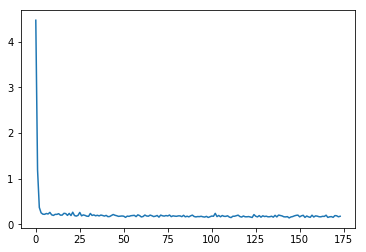

In [14]:
plt.plot(critic_losses)

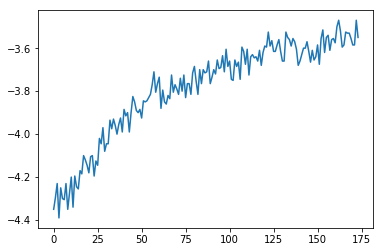

In [15]:
plt.plot(total_rewards)

In [16]:
env = Environment(
    'inst_2x2_7_0.txt',
    square_index=True,
    cost_function=degree_cost,
    simple_graph=True)

2018-11-23 18:17:51,893- INFO•	reading file inst_2x2_7_0.txt
2018-11-23 18:17:51,894- INFO•	There are 4 qubits in circuit
2018-11-23 18:17:51,896- INFO•	Generated graph with 10 nodes and 22 edges
2018-11-23 18:17:51,896- INFO•	last index contains from [9, 2, 5, 10]


In [17]:
s = env.reset()
l, tw = get_peo(env.graph, )
actions = [env.node_to_row[node] for node in l]

2018-11-23 18:17:57,184- INFO•	generating config file output/quickbb.cnf
2018-11-23 18:17:57,187- INFO•	excecuting quickbb: ./quickbb/quickbb_64 --min-fill-ordering --time 60 --cnffile output/quickbb.cnf 
2018-11-23 18:17:57,282- INFO•	b'\n8 4 3 9 6 10 7 5 2 1 \nTreewidth= 3\n'
2018-11-23 18:17:57,285- INFO•	Final peo from quickBB:
[8, 4, 3, 9, 6, 10, 7, 5, 2, 1]


In [27]:
env.reset()
env1 = copy.deepcopy(env)
env2 = copy.deepcopy(env)

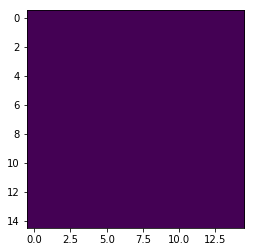

22 3


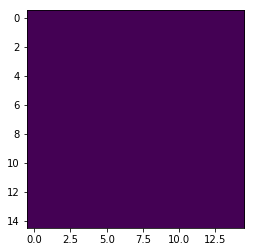

In [28]:
s = env1.reset()
costs = []
done = False

indices = []

for i in range(10):
    
    mask = env1.available_actions.copy()

    a, dist = algo.actor.forward(
        to_tensor(s[None, :, :, None]),
        mask=to_tensor(mask[None, :]),
        with_dist=True)
    a = a.cpu().detach().numpy()[0]
    indices.append(a)

    s, cost, done = env1.step(a)
    costs.append(cost)
    plt.imshow(s)
    display.clear_output(wait=True)
    display.display(plt.gcf())
print (np.sum(costs), np.max(costs))

In [32]:
nodes = [env1.row_to_node[idx] for idx in indices]

In [33]:
nodes

[10, 3, 1, 4, 9, 8, 7, 2, 5, 6]

In [31]:
env1.row_to_node

{5: 1, 11: 4, 0: 7, 2: 10, 4: 3, 9: 2, 7: 5, 8: 8, 10: 6, 6: 9}

In [25]:
costs

[2, 3, 1, 2, 1, 2, 3, 2, 3, 2]

In [21]:
get_peo??

In [ ]:
plt.plot(critic_losses)

In [ ]:
plt.plot(total_rewards)

In [34]:
import src.graph_model as gm

In [37]:
gm.get_treewidth_from_peo(env2.graph, nodes)

3